In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier #FOR ROC CURVE
from sklearn.metrics import cohen_kappa_score

In [2]:
df = pd.read_csv("df_norm.csv", 
                 index_col = 0)

In [27]:
class_names = df['CLASS']
class_names = class_names.tolist()
col_names = df.columns
class_label = np.unique(class_names)

In [4]:
df.shape

(200, 35)

In [5]:
X = df.drop('CLASS',axis=1)
Y = df['CLASS']

Binarizando... ou Melhor hot-enconding???  
Estou usando binarize devido a curva ROC, OneVsAll


In [6]:
Y_bin = label_binarize(df['CLASS'], 
                       classes=class_label)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y_bin, 
                                                    test_size=0.2,
                                                    stratify=class_names)
y_true = np.argmax(y_test, axis = 1) ## VETORIZANDO PARA AS FUNCOES ABAIXO

# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

In [11]:
RF = RandomForestClassifier(n_estimators = 100)
RF.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
# 10 folds with 10 repeats
n_splits = 10
seed = 7
cv = RepeatedStratifiedKFold(n_splits=n_splits, 
                             n_repeats=n_splits, 
                             random_state=seed)

In [13]:
n_scores = cross_validate(RF,
                          X, 
                          Y, 
                          scoring='accuracy', 
                          cv=cv, 
                          n_jobs=-1, 
                          error_score='raise')
print("Mean:", np.mean(n_scores['test_score']))

Mean: 0.9455


In [15]:
RF100_res = RF.predict(X_test)
y_pred_RF100 = np.argmax(RF100_res, axis=1)
y_predp_RF100 = RF.predict_proba(X_test)

In [16]:
RF100_cm = confusion_matrix(y_true=y_true, 
                            y_pred=y_pred_RF100)

Text(0.5, 1.0, 'Heatmap for RF100 Classification Model')

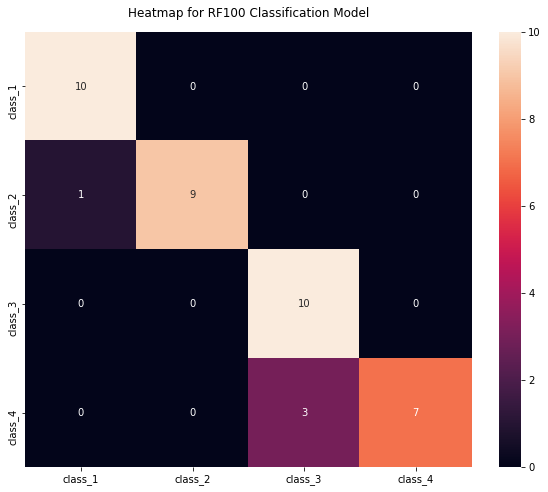

In [17]:
plt.figure(figsize = (10,8))
ax = plt.axes()
x_axis_labels = ['class_1', 'class_2', 'class_3', 'class_4'] # labels for x-axis
y_axis_labels = ['class_1', 'class_2', 'class_3', 'class_4'] # labels for y-axis
sns.heatmap(RF100_cm,
            vmin=0,
            vmax=10,
            annot=True,
            fmt="d",
            ax = ax,
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)
ax.set_title('Heatmap for RF100 Classification Model',pad=15)

In [18]:
print(classification_report(y_true, y_pred_RF100, target_names=class_label))
print("Accuracy:",metrics.accuracy_score(y_true, y_pred_RF100))

              precision    recall  f1-score   support

     class_1       0.91      1.00      0.95        10
     class_2       1.00      0.90      0.95        10
     class_3       0.77      1.00      0.87        10
     class_4       1.00      0.70      0.82        10

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40

Accuracy: 0.9


Selecionando as features mais usadas.... 

In [28]:
feature_imp = pd.Series(RF.feature_importances_,index=col_names.drop('CLASS')).sort_values(ascending=False)
feature_imp = feature_imp[feature_imp > 0]
feature_imp

DEG.1     0.180974
MT4.1     0.146184
MT3.1     0.133795
ASPL.2    0.107950
ASPL.1    0.071262
SD.1      0.048161
SD.2      0.038027
DEG.2     0.036705
ASS.1     0.034577
CC.1      0.029814
BET.1     0.024449
MAX.1     0.022559
ASS.2     0.022460
MT3.2     0.019154
BET.2     0.018856
MAX.2     0.014771
MIN.1     0.011644
ASPL.3    0.010828
MIN.2     0.008505
MT4.2     0.006651
SD.3      0.003611
MAX.3     0.003125
DEG.3     0.002290
MIN.3     0.001152
MIN.4     0.000794
ASPL.4    0.000637
MAX.4     0.000451
ASS.3     0.000305
MT3.3     0.000158
BET.3     0.000150
dtype: float64

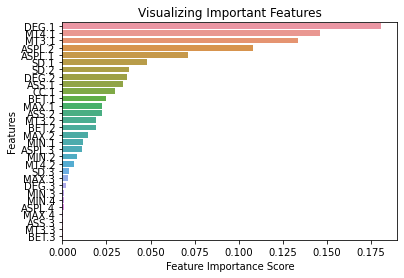

In [29]:
ax = sns.barplot(x=feature_imp, y=feature_imp.index)
ax.set_xlabel('Feature Importance Score')
ax.set_ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

ROC

In [30]:
RF_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100))
y_pred_ovr_RF100 = RF_clf.fit(X_train, y_train).predict_proba(X_test)

In [31]:
# Compute ROC curve and ROC area for each class
fpr_RF100 = dict()
tpr_RF100 = dict()
roc_auc_RF100 = dict()
for i in range(class_label.shape[0]):
    fpr_RF100[i], tpr_RF100[i], _ = roc_curve(y_test[:, i], y_pred_ovr_RF100[:, i])
    roc_auc_RF100[i] = auc(fpr_RF100[i], tpr_RF100[i])

CURVAS ROC ???? MUITO FORA..... QD COMPARADA COM A ACURACIA

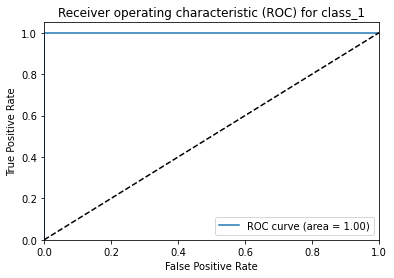

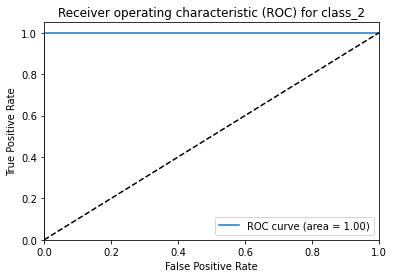

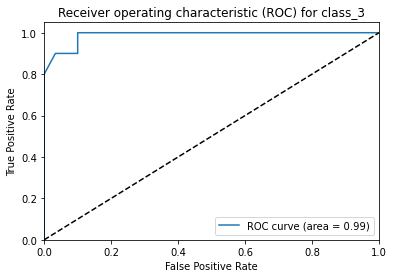

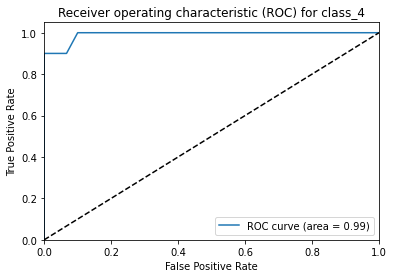

In [32]:
for i in range(class_label.shape[0]):
    plt.figure()
    plt.plot(fpr_RF100[i], tpr_RF100[i], label='ROC curve (area = %0.2f)' % roc_auc_RF100[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) for %s' % class_label[i])
    plt.legend(loc="lower right")
    plt.show()

In [33]:
RF100_kappa = cohen_kappa_score(y_true, y_pred_RF100)
RF100_kappa

0.8666666666666667

In [34]:
FP = RF100_cm.sum(axis=0) - np.diag(RF100_cm) 
FN = RF100_cm.sum(axis=1) - np.diag(RF100_cm)
TP = np.diag(RF100_cm)
TN = RF100_cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensibilidade, taxa de acerto, recall ou taxa de true positive 
TPR = TP/(TP+FN)
print("Sensibilidade:\t", TPR)
# Especificidade ou taxa de true negative
TNR = TN/(TN+FP) 
print("True Negative:\t", TNR)
# Precisao
PPV = TP/(TP+FP)
print("Precisão:\t", PPV)
# Predicao negativa
NPV = TN/(TN+FN)
print("Pred. Negativa:\t", NPV)
# False positive
FPR = FP/(FP+TN)
print("False Positive: ", FPR)
# False negative
FNR = FN/(TP+FN)
print("False Negative:\t", FNR)
# False discovery
FDR = FP/(TP+FP)
print("F Discovery:\t", FDR)
# Accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Acurácia:\t", ACC)

Sensibilidade:	 [1.  0.9 1.  0.7]
True Negative:	 [0.96666667 1.         0.9        1.        ]
Precisão:	 [0.90909091 1.         0.76923077 1.        ]
Pred. Negativa:	 [1.         0.96774194 1.         0.90909091]
False Positive:  [0.03333333 0.         0.1        0.        ]
False Negative:	 [0.  0.1 0.  0.3]
F Discovery:	 [0.09090909 0.         0.23076923 0.        ]
Acurácia:	 [0.975 0.975 0.925 0.925]
